# Supervised Learning:  The Waze Carpool - SF Pilot
- In this project, I'm trying to build machine learning models based on Kaggle and SMFTA's data: I came up with WAZE Rider San Francisco Pilot to study features of a carpool modelling and make prdedictions that could help the business.
Waze is going the corporate route. The pilot is starting with more than 25,000 employees of select companies that schlep workers from city.

Income: information about total pay, total pay benefits and overtime pay for San Francisco residents

In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn import linear_model, cross_validation
from sklearn import tree, ensemble, metrics, cross_validation, externals

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_dataset():
    return pd.read_csv(os.path.join('..', 'FinalProject-GA', 'Salaries.csv'))

df = read_dataset()

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (3,4,5,6,12) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
df = pd.read_csv(os.path.join('..', 'FinalProject-GA', 'Salaries.csv'))

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3,4,5,6,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## The Dataset

In [4]:
df

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,...,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,...,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245132,...,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739,106088,...,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916,56120.7,...,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134402,9737,...,326373.19,2011,NaN,San Francisco,NaN
...,...,...,...,...,...,...,...,...,...,...,...
148649,148650,Roy I Tillery,Custodian,0.00,0.00,...,0.00,2014,NaN,San Francisco,PT
148650,148651,Not provided,Not provided,Not Provided,Not Provided,...,0.00,2014,NaN,San Francisco,NaN
148651,148652,Not provided,Not provided,Not Provided,Not Provided,...,0.00,2014,NaN,San Francisco,NaN
148652,148653,Not provided,Not provided,Not Provided,Not Provided,...,0.00,2014,NaN,San Francisco,NaN


# Data Cleaning and Transformation

In [5]:
df.columns

Index([u'Id', u'EmployeeName', u'JobTitle', u'BasePay', u'OvertimePay',
       u'OtherPay', u'Benefits', u'TotalPay', u'TotalPayBenefits', u'Year',
       u'Notes', u'Agency', u'Status'],
      dtype='object')

In [6]:
## Variables and Strings

In [7]:
##Dropping 'Notes' as the columns has no information
df.Notes.unique()

array([ nan])

In [8]:
df.drop('Notes', axis=1, inplace=True)

In [9]:
##Dropping 'Agency' as the columns are all the same location: San Francisco
df.Agency.unique()

array(['San Francisco'], dtype=object)

In [10]:
df.drop('Agency', axis=1, inplace=True)

In [11]:
##Tidying up the 'Status' as the columns are : PartTime or FullTime - Keep as a predictor 
df.Status.unique()

array([nan, 'PT', 'FT'], dtype=object)

In [12]:
df.Status = df.Status.\
    apply(lambda Status: 'PartTime' if Status == 'PT' else Status)
    
df.Status = df.Status.\
    apply(lambda Status: 'FullTime' if Status == 'FT' else Status) 

In [13]:
df.Status.unique()

array([nan, 'PartTime', 'FullTime'], dtype=object)

In [14]:
df.Status.value_counts()

FullTime    22334
PartTime    15785
Name: Status, dtype: int64

In [15]:
df.TotalPay.unique()

array([  5.67595430e+05,   5.38909280e+05,   3.35279910e+05, ...,
         1.28900000e+01,   6.00000000e+00,  -6.18130000e+02])

In [16]:
df.TotalPay.value_counts()

0.00         368
18594.00      82
123290.70     56
132242.50     49
105489.00     42
            ... 
80032.09       1
5855.02        1
100268.68      1
882.50         1
32056.50       1
Name: TotalPay, dtype: int64

In [17]:
df.TotalPayBenefits.unique()

array([  5.67595430e+05,   5.38909280e+05,   3.35279910e+05, ...,
         1.28900000e+01,   7.24000000e+00,  -6.18130000e+02])

In [18]:
df.TotalPayBenefits.value_counts()

7959.18      263
123290.70     56
132242.50     49
26058.70      43
105489.00     42
            ... 
71018.91       1
149276.36      1
71524.39       1
250176.84      1
32056.50       1
Name: TotalPayBenefits, dtype: int64

In [19]:
df.JobTitle.unique()

array(['GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY',
       'CAPTAIN III (POLICE DEPARTMENT)',
       'WIRE ROPE CABLE MAINTENANCE MECHANIC', ..., 'Conversion',
       'Cashier 3', 'Not provided'], dtype=object)

In [20]:
## Lets see how many missing values the data set has

In [21]:
df.isnull().sum()

Id                       0
EmployeeName             0
JobTitle                 0
BasePay                605
OvertimePay              0
                     ...  
Benefits             36159
TotalPay                 0
TotalPayBenefits         0
Year                     0
Status              110535
dtype: int64

# PROJECT 3

### Exploratory Data Analysis

In [22]:
## Cleaning up the 'Job Title' and 'Employee Name' in exiting string format and convert them into numeric values

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df.JobTitle = le.fit_transform(df.JobTitle)

In [24]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df.JobTitle = le.fit_transform(df.EmployeeName)

In [25]:
df.describe()

,Id,JobTitle,TotalPay,TotalPayBenefits,Year
count,148654.000000,148654.000000,148654.000000,148654.000000,148654.000000
mean,74327.500000,55617.763431,74768.321972,93692.554811,2012.522643
std,42912.857795,31927.647179,50517.005274,62793.533483,1.117538
min,1.000000,0.000000,-618.130000,-618.130000,2011.000000
25%,37164.250000,27892.000000,36168.995000,44065.650000,2012.000000
50%,74327.500000,55688.500000,71426.610000,92404.090000,2013.000000
75%,111490.750000,83062.000000,105839.135000,132876.450000,2014.000000
max,148654.000000,110810.000000,567595.430000,567595.430000,2014.000000


In [26]:
df.TotalPay.describe()

count    148654.000000
mean      74768.321972
std       50517.005274
min        -618.130000
25%       36168.995000
50%       71426.610000
75%      105839.135000
max      567595.430000
Name: TotalPay, dtype: float64

In [27]:
## There is a mis-stated invoice min.value: '-618.13'

In [28]:
df[df.TotalPay < 0]

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,...,Benefits,TotalPay,TotalPayBenefits,Year,Status
148653,148654,Joe Lopez,50065,0.00,0.00,...,0.00,-618.13,-618.13,2014,PartTime


In [29]:
## Getting rid of row with TotalPay = "-618.13" - no longer valid now.
df = df[df.EmployeeName.str.contains("Joe Lopez") == False]

In [30]:
## The people with O and less than 100 $ TotalPay
## Some of them are getting benefits. Perhaps they’re retired, on disability, or something else?

In [31]:
df[df.TotalPay == 0]

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,...,Benefits,TotalPay,TotalPayBenefits,Year,Status
36156,36157,PAULETTE ADAMS,80802,0,0,...,NaN,0.0,0.00,2011,NaN
36157,36158,KAUKAB MOHSIN,54718,0,0,...,NaN,0.0,0.00,2011,NaN
36158,36159,JOSEPHINE MCCREARY,44518,0,0,...,NaN,0.0,0.00,2011,NaN
70877,70878,Roland Baylon,90560,0,0,...,3728.05,0.0,3728.05,2012,NaN
70927,70928,Felecia Phillips,33127,0,0,...,3618.13,0.0,3618.13,2012,NaN
...,...,...,...,...,...,...,...,...,...,...,...
148648,148649,Leon Walker,62496,0.00,0.00,...,0.00,0.0,0.00,2014,PartTime
148649,148650,Roy I Tillery,91653,0.00,0.00,...,0.00,0.0,0.00,2014,PartTime
148650,148651,Not provided,79495,Not Provided,Not Provided,...,Not Provided,0.0,0.00,2014,NaN
148651,148652,Not provided,79495,Not Provided,Not Provided,...,Not Provided,0.0,0.00,2014,NaN


In [32]:
df[df.TotalPay < 100]

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,...,Benefits,TotalPay,TotalPayBenefits,Year,Status
36070,36071,CLARENCE JOHNSON,14236,99.1,0,...,NaN,99.10,99.10,2011,NaN
36071,36072,RONALD TERASHIMA,86024,0,0,...,NaN,98.10,98.10,2011,NaN
36072,36073,LINDSAY PALAIMA,60320,98,0,...,NaN,98.00,98.00,2011,NaN
36073,36074,FIAMMA GIGER,32498,98,0,...,NaN,98.00,98.00,2011,NaN
36074,36075,CHERI COLLINS,13590,0,0,...,NaN,97.73,97.73,2011,NaN
...,...,...,...,...,...,...,...,...,...,...,...
148648,148649,Leon Walker,62496,0.00,0.00,...,0.00,0.00,0.00,2014,PartTime
148649,148650,Roy I Tillery,91653,0.00,0.00,...,0.00,0.00,0.00,2014,PartTime
148650,148651,Not provided,79495,Not Provided,Not Provided,...,Not Provided,0.00,0.00,2014,NaN
148651,148652,Not provided,79495,Not Provided,Not Provided,...,Not Provided,0.00,0.00,2014,NaN


In [33]:
## Getting rid of rows with TotalPay = "0" - no longer valid now.
## Getting rid of rows with TotalPay < 100 - no longer valid now.
df = df[df.TotalPay != 0]
df = df.drop(df[df.TotalPay < 100].index)

In [34]:
## Selecting the data
subset_df = df[(df.Status == 'FullTime')]

subset_df.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,...,Benefits,TotalPay,TotalPayBenefits,Year,Status
110532,110533,Amy P Hart,5513,318835,10713,...,89540.2,390111.98,479652.21,2014,FullTime
110534,110535,Gregory P Suhr,37519,307450,0,...,91302.5,326716.76,418019.22,2014,FullTime
110535,110536,Joanne M Hayes-White,49885,302068,0,...,91201.7,326233.44,417435.10,2014,FullTime
110536,110537,Ellen G Moffatt,30367,270222,6009.22,...,71580.5,344187.46,415767.94,2014,FullTime
110537,110538,John L Martin,50815,311299,0,...,89772.3,311298.55,401070.87,2014,FullTime


In [35]:
df.dropna(subset = ['BasePay', 'Benefits', 'Status'])

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,...,Benefits,TotalPay,TotalPayBenefits,Year,Status
110531,110532,David Shinn,24407,129150,0,...,38780,471952.64,510732.68,2014,PartTime
110532,110533,Amy P Hart,5513,318835,10713,...,89540.2,390111.98,479652.21,2014,FullTime
110533,110534,William J Coaker Jr.,108225,257340,0,...,96570.7,339653.70,436224.36,2014,PartTime
110534,110535,Gregory P Suhr,37519,307450,0,...,91302.5,326716.76,418019.22,2014,FullTime
110535,110536,Joanne M Hayes-White,49885,302068,0,...,91201.7,326233.44,417435.10,2014,FullTime
...,...,...,...,...,...,...,...,...,...,...,...
148536,148537,Kevin W Harper,58141,100.00,0.00,...,1.00,100.00,101.00,2014,PartTime
148537,148538,Ken Prag,57191,100.00,0.00,...,1.00,100.00,101.00,2014,PartTime
148538,148539,Roy Kaushik,91657,100.00,0.00,...,1.00,100.00,101.00,2014,PartTime
148539,148540,Hope A Schmeltzer,39754,100.00,0.00,...,0.00,100.00,100.00,2014,PartTime


In [36]:
# Creating Dummy Variables
year_df = pd.get_dummies(df.Year, prefix = 'Year')
status_df = pd.get_dummies(df.Status, prefix = 'Status')

df = df.join([year_df, status_df])

df.columns

Index([u'Id', u'EmployeeName', u'JobTitle', u'BasePay', u'OvertimePay',
       u'OtherPay', u'Benefits', u'TotalPay', u'TotalPayBenefits', u'Year',
       u'Status', u'Year_2011', u'Year_2012', u'Year_2013', u'Year_2014',
       u'Status_FullTime', u'Status_PartTime'],
      dtype='object')

#### Job Status & Total Pay

In [37]:
# SF Salaries by JobType

In [38]:
## Lets find the outliers - Median & Range

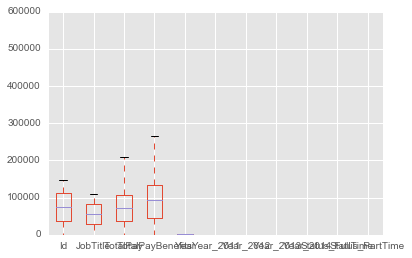

In [39]:
df.plot(kind = 'box')

Id, Job Title and Total Pay are symmetrically distributed with no outliers. Total Pay Benefits does have any outliers and seems to be Skewed to the left.

In [40]:
def drop_outliers(df):
    print 'Dropping outliers'
    print '- n (before) =', len(df)

    Q1 = df.TotalPayBenefits.quantile(.25)
    Q2 = df.TotalPayBenefits.quantile(.5)
    Q3 = df.TotalPayBenefits.quantile(.75)
    IQR = Q3 - Q1

    print '- Q1         =', Q1, '($M)'
    print '- Q2/Median  =', Q2, '($M)'
    print '- Q3         =', Q3, '($M)'

    df.drop(df[df.TotalPayBenefits > Q3 + 1.5 * IQR].index, inplace = True)

    print '- n (after)  =', len(df)
    
drop_outliers(df)

Dropping outliers
- n (before) = 147887
- Q1         = 45349.605 ($M)
- Q2/Median  = 92756.25 ($M)
- Q3         = 133149.635 ($M)
- n (after)  = 146898


In [41]:
## Mode

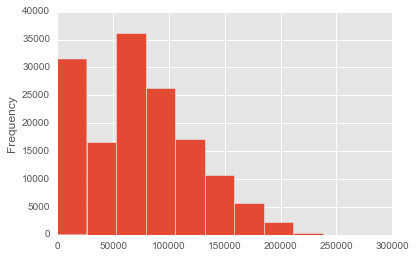

In [42]:
df.TotalPay.plot(kind = 'hist')

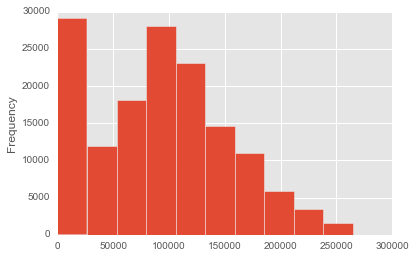

In [43]:
df.TotalPayBenefits.plot(kind = 'hist')

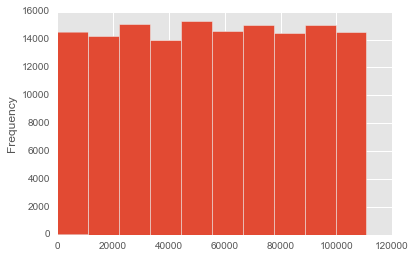

In [44]:
df.JobTitle.plot(kind = 'hist')

In [45]:
df.Benefits.unique()

array([nan, 48089.3, 66833.19, ..., '1.04', '1.02', '1.00'], dtype=object)

In [46]:
df.dropna()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,...,Year_2012,Year_2013,Year_2014,Status_FullTime,Status_PartTime
110857,110858,Sandra K Schwarcz,95123,207036,0,...,0.0,0.0,1.0,1.0,0.0
110858,110859,Luis A Ibarra-Rivera,64797,130961,62529.9,...,0.0,0.0,1.0,1.0,0.0
110859,110860,Jennifer E Matz,48253,200308,0,...,0.0,0.0,1.0,1.0,0.0
110860,110861,Steven P Thompson,99102,205036,0,...,0.0,0.0,1.0,1.0,0.0
110861,110862,Eddie J Hagan,28886,142996,57546.5,...,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
148536,148537,Kevin W Harper,58141,100.00,0.00,...,0.0,0.0,1.0,0.0,1.0
148537,148538,Ken Prag,57191,100.00,0.00,...,0.0,0.0,1.0,0.0,1.0
148538,148539,Roy Kaushik,91657,100.00,0.00,...,0.0,0.0,1.0,0.0,1.0
148539,148540,Hope A Schmeltzer,39754,100.00,0.00,...,0.0,0.0,1.0,0.0,1.0


In [47]:
## Correlation

In [48]:
df.corr()

,Id,JobTitle,TotalPay,TotalPayBenefits,Year,...,Year_2012,Year_2013,Year_2014,Status_FullTime,Status_PartTime
Id,1.000000,0.032402,-0.216823,-0.091983,0.968976,...,-0.261633,0.236651,0.757745,0.479288,0.518096
JobTitle,0.032402,1.000000,0.005954,0.014880,0.034738,...,0.017756,0.014053,0.014535,0.012452,0.006165
TotalPay,-0.216823,0.005954,1.000000,0.975579,0.025671,...,-0.008380,0.030889,0.004257,0.238922,-0.270719
TotalPayBenefits,-0.091983,0.014880,0.975579,1.000000,0.150730,...,0.065304,0.071727,0.059822,0.302031,-0.265117
Year,0.968976,0.034738,0.025671,0.150730,1.000000,...,-0.265457,0.249194,0.777218,0.556130,0.456671
...,...,...,...,...,...,...,...,...,...,...,...
Year_2012,-0.261633,0.017756,-0.008380,0.065304,-0.265457,...,1.000000,-0.331926,-0.336785,-0.240983,-0.197885
Year_2013,0.236651,0.014053,0.030889,0.071727,0.249194,...,-0.331926,1.000000,-0.339523,-0.242942,-0.199494
Year_2014,0.757745,0.014535,0.004257,0.059822,0.777218,...,-0.336785,-0.339523,1.000000,0.715539,0.587572
Status_FullTime,0.479288,0.012452,0.238922,0.302031,0.556130,...,-0.240983,-0.242942,0.715539,1.000000,-0.144835


In [49]:
## 'TotalPay' and 'TotalPayBenefits' seem to be strongly correlated (at 0.97) 

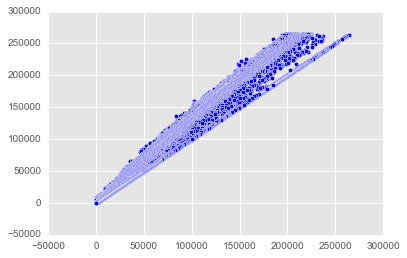

array([[ 1.        ,  0.97557901],
       [ 0.97557901,  1.        ]])

In [50]:
plt.scatter(df.TotalPay, df.TotalPayBenefits)
plt.show()
np.corrcoef(df.TotalPay, df.TotalPayBenefits)

In [51]:
## 'TotalPay' and 'JobTitle" don't seem to be strongly correlated (at 0.007)

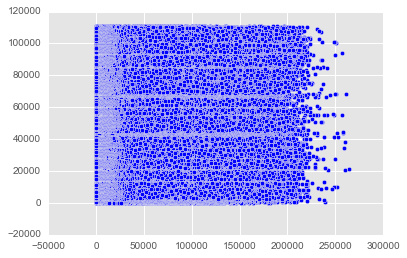

array([[ 1.        ,  0.00595414],
       [ 0.00595414,  1.        ]])

In [52]:
plt.scatter(df.TotalPay, df.JobTitle)
plt.show()
np.corrcoef(df.TotalPay, df.JobTitle)

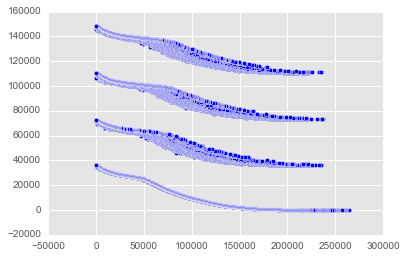

array([[ 1.        , -0.21682263],
       [-0.21682263,  1.        ]])

In [53]:
## 'TotalPay' and 'Id' seem to be negatively correlated at -0.20 
## retain both as predictors for now.
plt.scatter(df.TotalPay, df.Id)
plt.show()
np.corrcoef(df.TotalPay, df.Id)

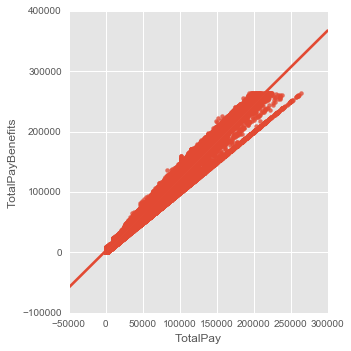

In [54]:
sns.lmplot(x = 'TotalPay', y = 'TotalPayBenefits', data = df)

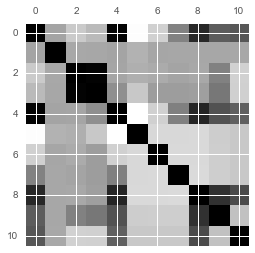

In [55]:
plt.matshow(df.corr())

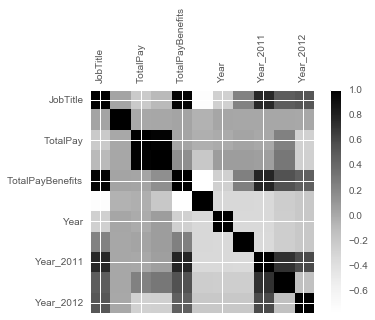

In [56]:
corr = df.corr()

figure = plt.figure()
subplot = figure.add_subplot(1, 1, 1)
figure.colorbar(subplot.matshow(df.corr()))
subplot.set_xticklabels(corr.columns, rotation = 90)
subplot.set_yticklabels(corr.columns)
plt.show()

# PROJECT 4

In [57]:
model = smf.ols(formula = 'TotalPay ~ TotalPayBenefits', data = df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalPay   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 2.898e+06
Date:                Tue, 12 Jul 2016   Prob (F-statistic):               0.00
Time:                        17:55:30   Log-Likelihood:            -1.5709e+06
No. Observations:              146898   AIC:                         3.142e+06
Df Residuals:                  146896   BIC:                         3.142e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         1410.0629     50.939     27.681      0.000      1310.223  1509.902
TotalPayBenefits     0.7826      0.000   1702.310      0.000         0.782     0.783
==============================================================================
Omnibus:                    32352.449   Durbin-Watson:                   0.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61880.797
Skew:                           1.364   Prob(JB):                         0.00
Kurtosis:                       4.634   Cond. No.                     2.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
model.fvalue

2897859.065073132

In [59]:
model.rsquared

0.95175441148450091

### Checking modeling assumption

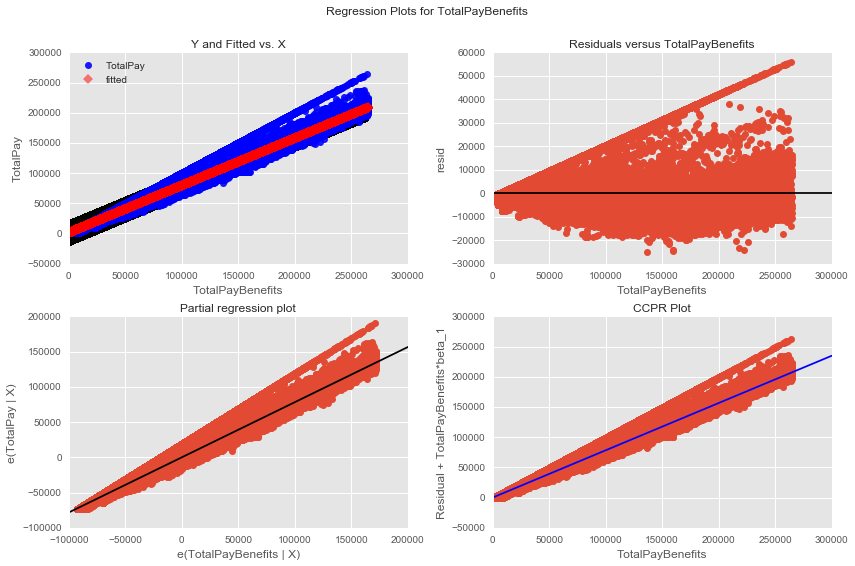

In [60]:
figure = plt.figure(figsize = (12, 8))
figure = sm.graphics.plot_regress_exog(model, 'TotalPayBenefits', fig = figure)

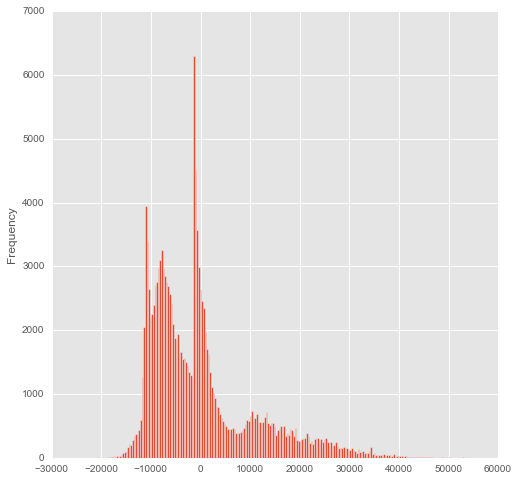

In [61]:
model = smf.ols(formula = 'TotalPay ~ TotalPayBenefits', data = df).fit()

model.resid.plot(kind = 'hist', bins = 250, figsize = (8, 8))

plt.show()

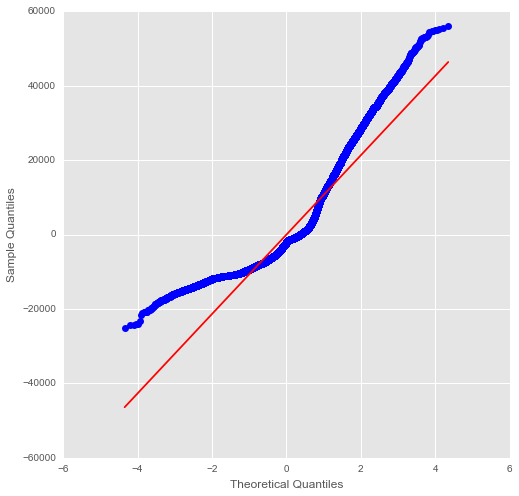

In [62]:
figure, ax = plt.subplots(figsize = (8, 8))
figure = sm.qqplot(model.resid, line = 's', ax = ax)

plt.show()

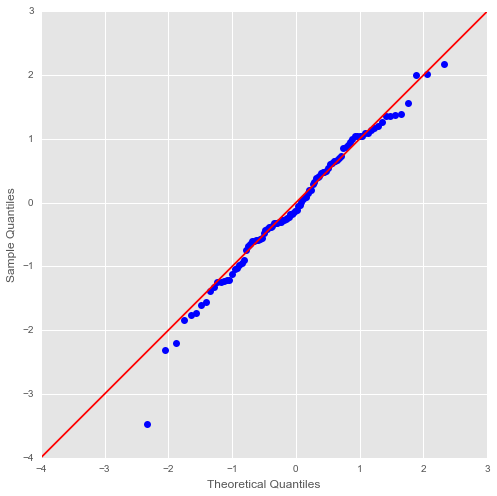

In [63]:
normal_array = np.random.normal(0, 1, size = 100)

figure, ax = plt.subplots(figsize = (8, 8))
figure = sm.qqplot(normal_array, line = '45', ax = ax)
plt.show()

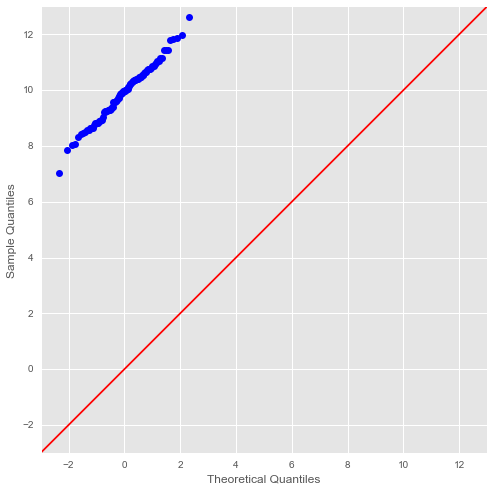

In [64]:
normal_array = np.random.normal(10, 1, size = 100)

figure, ax = plt.subplots(figsize = (8, 8))
figure = sm.qqplot(normal_array, line = '45', ax = ax)
plt.show()

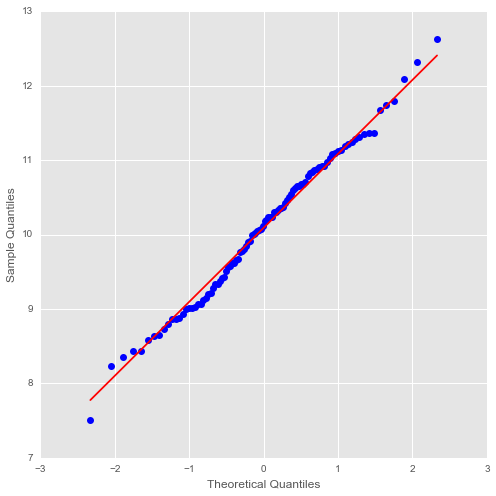

In [65]:
normal_array = np.random.normal(10, 1, size = 100)

figure, ax = plt.subplots(figsize = (8, 8))
figure = sm.qqplot(normal_array, line = 's', ax = ax)
plt.show()

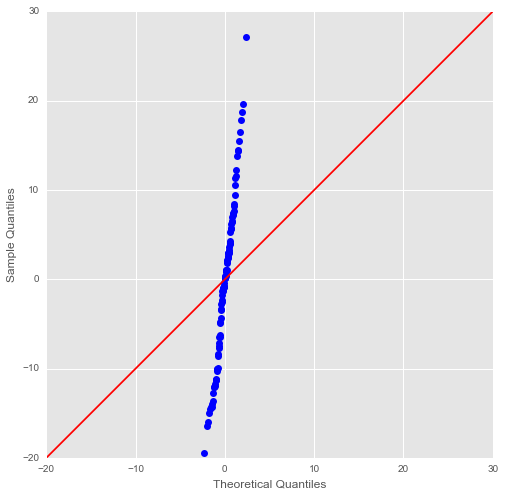

In [66]:
normal_array = np.random.normal(0, 10, size = 100)

figure, ax = plt.subplots(figsize = (8, 8))
figure = sm.qqplot(normal_array, line = '45', ax = ax)
plt.show()

In [67]:
model = smf.ols(formula = 'TotalPay ~ 0 + TotalPayBenefits', data = df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalPay   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 9.922e+06
Date:                Tue, 12 Jul 2016   Prob (F-statistic):               0.00
Time:                        17:55:47   Log-Likelihood:            -1.5713e+06
No. Observations:              146898   AIC:                         3.143e+06
Df Residuals:                  146897   BIC:                         3.143e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
TotalPayBenefits     0.7932      0.000   3149.998      0.000         0.793     0.794
==============================================================================
Omnibus:                    28723.420   Durbin-Watson:                   0.223
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50481.796
Skew:                           1.272   Prob(JB):                         0.00
Kurtosis:                       4.332   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Inference and Fit

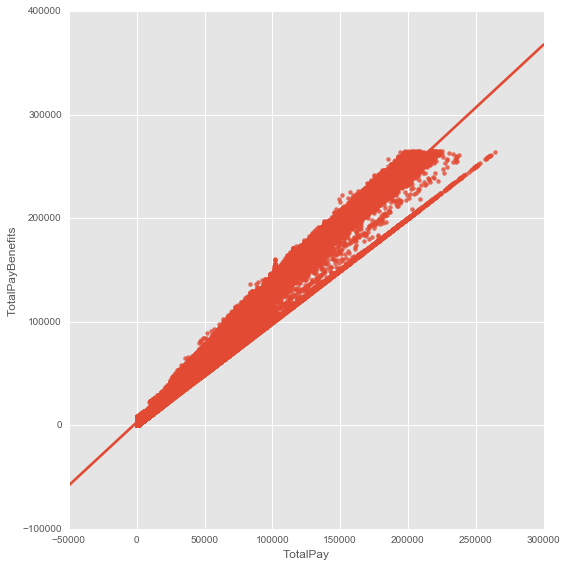

In [68]:
sns.lmplot('TotalPay', 'TotalPayBenefits', df, size = 8)

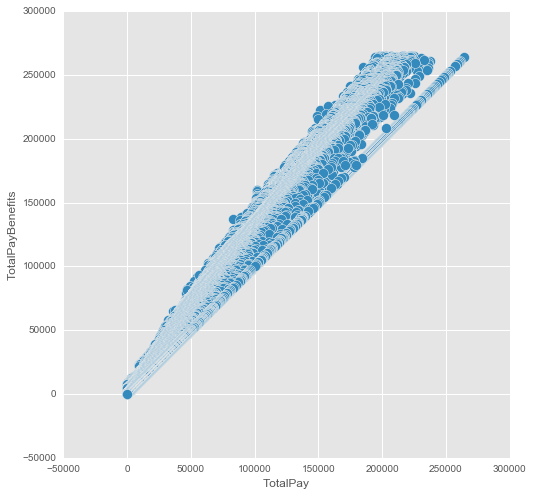

In [69]:
df[ ['TotalPay', 'TotalPayBenefits'] ].plot(kind = 'scatter', x = 'TotalPay', y = 'TotalPayBenefits', s = 100, figsize = (8, 8))

Adding JobTitle did not improve R2 significantly vs. TotalPayBenefits alone.

### Cross-Validation

In [70]:
train_df = df.sample(frac = .6, random_state = 0).sort_index()

In [71]:
train_df

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,...,Year_2012,Year_2013,Year_2014,Status_FullTime,Status_PartTime
28,29,DENISE SCHMITT,21278,261718,0,...,0.0,0.0,0.0,0.0,0.0
29,30,MONICA FIELDS,68587,246226,0,...,0.0,0.0,0.0,0.0,0.0
31,32,DAVID SHINN,20879,254028,0,...,0.0,0.0,0.0,0.0,0.0
34,35,JOSE VELO,44218,177781,59925,...,0.0,0.0,0.0,0.0,0.0
36,37,SUSAN CURRIN,94278,245124,0,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
148536,148537,Kevin W Harper,58141,100.00,0.00,...,0.0,0.0,1.0,0.0,1.0
148537,148538,Ken Prag,57191,100.00,0.00,...,0.0,0.0,1.0,0.0,1.0
148538,148539,Roy Kaushik,91657,100.00,0.00,...,0.0,0.0,1.0,0.0,1.0
148539,148540,Hope A Schmeltzer,39754,100.00,0.00,...,0.0,0.0,1.0,0.0,1.0


In [72]:
test_df = df.drop(train_df.index)

In [73]:
test_df 

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,...,Year_2012,Year_2013,Year_2014,Status_FullTime,Status_PartTime
30,31,HARLAN KELLY-JR,37912,234325,0,...,0.0,0.0,0.0,0.0,0.0
32,33,GARY AMELIO,34367,248896,0,...,0.0,0.0,0.0,0.0,0.0
33,34,JOHN TURSI,43755,104861,50227.6,...,0.0,0.0,0.0,0.0,0.0
35,36,KHOA TRINH,55306,101953,139103,...,0.0,0.0,0.0,0.0,0.0
38,39,JONES WONG,43991,132202,52648.9,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
148518,148519,Juan F Castro,53331,110.20,0.00,...,0.0,0.0,1.0,0.0,1.0
148520,148521,Robert J Gowan,89587,0.00,0.00,...,0.0,0.0,1.0,0.0,1.0
148524,148525,Alicia N Wiley Powell,4614,0.00,0.00,...,0.0,0.0,1.0,0.0,1.0
148530,148531,Janet N Qiu,46783,104.90,0.00,...,0.0,0.0,1.0,0.0,1.0


In [74]:
# Generate the feature vector and target variable
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn import neighbors, metrics, grid_search, cross_validation

In [75]:
train_df = df.sample(frac = .6, random_state = 1)
test_df = df.drop(train_df.index)

In [76]:
len(train_df)

88139

In [77]:
train_X = train_df[ ['TotalPay', 'JobTitle'] ]
train_y = train_df.TotalPayBenefits

model = linear_model.LinearRegression()
cross_validation.cross_val_score(model, train_X, train_y, cv = 10).mean()

0.95173433695656462

In [78]:
def linear_modeling_with_sklearn(X, y):
    model = linear_model.LinearRegression()
    model.fit(X, y)

    print 'R^2 =', model.score(X, y)
    print 'Coefficients'
    print '- beta_0 (intercept) =', model.intercept_
    print '- beta_n (n > 0)     =', model.coef_

    return model

In [79]:
train_X = train_df[ ['TotalPay', 'JobTitle'] ]
train_y = train_df.TotalPayBenefits

model = linear_modeling_with_sklearn(train_X, train_y)

R^2 = 0.951747350895
Coefficients
- beta_0 (intercept) = 1740.21958961
- beta_n (n > 0)     = [ 1.21584428  0.01750271]


## Desicion Trees

In [88]:
df = df[df.EmployeeName.str.contains("ANA SAMPERA") == False]
df = df[df.Benefits.str.contains("Not Provided") == False]
df = df[df.OvertimePay.str.contains("Not Provided") == False]
df = df[df.JobTitle.str.contains("Not Provided") == False]
df.drop('EmployeeName', axis=1, inplace=True)
df.drop('Status', axis=1, inplace=True)
df.drop('Agency', axis=1, inplace=True)
df.drop('JobTitle', axis=1, inplace=True)

In [89]:
X = df[df.columns.values]
X.drop('TotalPay', axis = 1, inplace = True)

y = df.TotalPay

In [90]:
train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y, test_size = 0.4)

In [91]:
model = tree.DecisionTreeRegressor()

model.fit(train_X, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [92]:
cross_validation.cross_val_score(model, train_X, train_y, cv = 10).mean()

0.99911874385492838

In [93]:
train_y_hat = model.predict(train_X)
print np.sqrt(metrics.mean_squared_error(train_y, train_y_hat))

test_y_hat = model.predict(test_X)
print np.sqrt(metrics.mean_squared_error(test_y, test_y_hat))

2.55874216191e-13
633.33687082


In [94]:
model.score(test_X, test_y)

0.99927422698631019

In [ ]:
## the model that has high significant levels as we see through the test and train data score